In [52]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/Potato disease Project/PlantVillage", 
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
N_CLASSES=len(class_names)
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

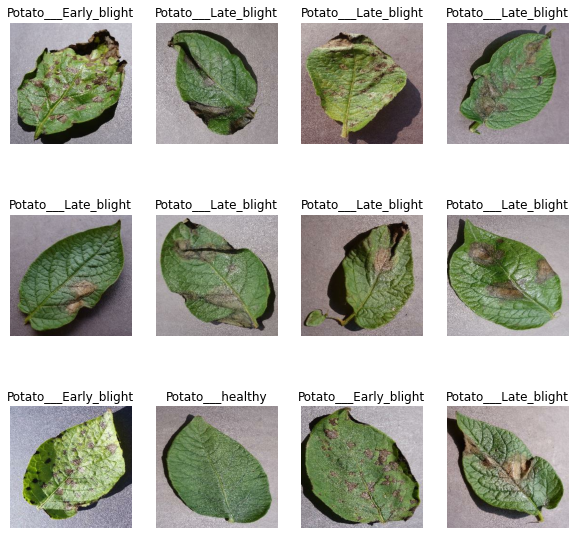

In [5]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax =plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")


In [6]:
train_size=0.8
train_ds=dataset.take(int(len(dataset)*train_size))
len(train_ds)

54

In [7]:
test_ds=dataset.skip(len(train_ds))
len(test_ds)

14

In [8]:
val_size=0.1
val_ds=test_ds.take(int(len(dataset)*val_size))
len(val_ds)

6

In [9]:
test_ds=test_ds.skip(len(val_ds))
len(test_ds)

8

In [10]:
def train_test_split(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size=len(ds)    
    
    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=12)
    
    train_ds=ds.take(int(ds_size*train_split))
    test_ds=ds.skip(len(train_ds))
    val_ds=test_ds.take(int(ds_size*val_split))
    test_ds=test_ds.skip(len(val_ds))
    
    return train_ds, val_ds, test_ds

In [25]:
train_ds, val_ds, test_ds = train_test_split(dataset)
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

54
6
8


In [26]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
resize_and_rescale = tf.keras.Sequential([
    keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    keras.layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [14]:
data_augmentation=tf.keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

In [30]:
model=keras.models.Sequential([
    resize_and_rescale,
    data_augmentation,
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(N_CLASSES, activation="softmax")
])

model.build(input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

In [31]:
model.compile(
    optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [32]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [33]:
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 [==============================] - 9s 137ms/step - loss: 0.8857 - accuracy: 0.5179 - val_loss: 0.8228 - val_accuracy: 0.6094
Epoch 2/50
54/54 [==============================] - 7s 133ms/step - loss: 0.5779 - accuracy: 0.7517 - val_loss: 0.7488 - val_accuracy: 0.6719
Epoch 3/50
54/54 [==============================] - 7s 132ms/step - loss: 0.3930 - accuracy: 0.8310 - val_loss: 0.3548 - val_accuracy: 0.8490
Epoch 4/50
54/54 [==============================] - 7s 132ms/step - loss: 0.2797 - accuracy: 0.8860 - val_loss: 0.2425 - val_accuracy: 0.8802
Epoch 5/50
54/54 [==============================] - 7s 133ms/step - loss: 0.2336 - accuracy: 0.9057 - val_loss: 0.2669 - val_accuracy: 0.8958
Epoch 6/50
54/54 [==============================] - 7s 132ms/step - loss: 0.2055 - accuracy: 0.9230 - val_loss: 0.2422 - val_accuracy: 0.8906
Epoch 7/50
54/54 [==============================] - 7s 132ms/step - loss: 0.1843 - accuracy: 0.9277 - val_loss: 0.1868 - val_accuracy: 0.9219
Epoch 

In [34]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 1s 62ms/step - loss: 0.0181 - accuracy: 0.9844


In [35]:
scores

[0.018123243004083633, 0.984375]

In [36]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [37]:
loss=history.history['loss']
acc=history.history['accuracy']
val_loss=history.history['val_loss']
val_acc=history.history['val_accuracy']


Text(0.5, 1.0, 'TRAINING and VALIDATION LOSS')

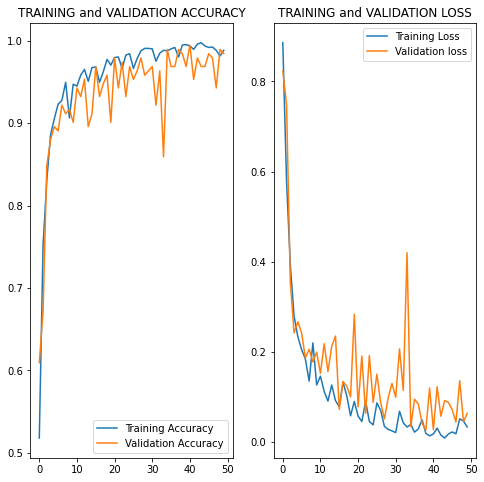

In [38]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label="Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label= "Validation Accuracy")
plt.legend(loc="lower right")
plt.title("TRAINING and VALIDATION ACCURACY")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label="Training Loss")
plt.plot(range(EPOCHS), val_loss, label="Validation loss")
plt.legend(loc="upper right")
plt.title("TRAINING and VALIDATION LOSS")

First Image to predict
Actual label: Potato___Early_blight
Predicted Label : Potato___Early_blight


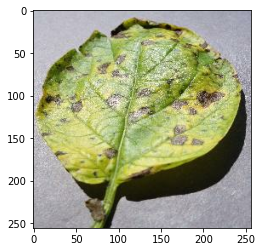

In [39]:
for images_batch, label_batch in test_ds.take(1):
  first_image=images_batch[0].numpy().astype('uint8')
  first_label=label_batch[0].numpy()

  print("First Image to predict")
  plt.imshow(first_image)
  print("Actual label:", class_names[first_label])
  
  batch_pred=model.predict(images_batch)
  print("Predicted Label :",class_names[np.argmax(batch_pred[0])])


In [63]:
def predict(model, img):
  img_array=tf.keras.preprocessing.image.img_to_array(img.numpy())
  img_array=tf.expand_dims(img_array, 0)
  
  
  predictions=model.predict(img_array)
  
  predicted_class=class_names[np.argmax(predictions[0])]
  confidence=round(100*(np.max(predictions[0])),2)

  return predicted_class, confidence

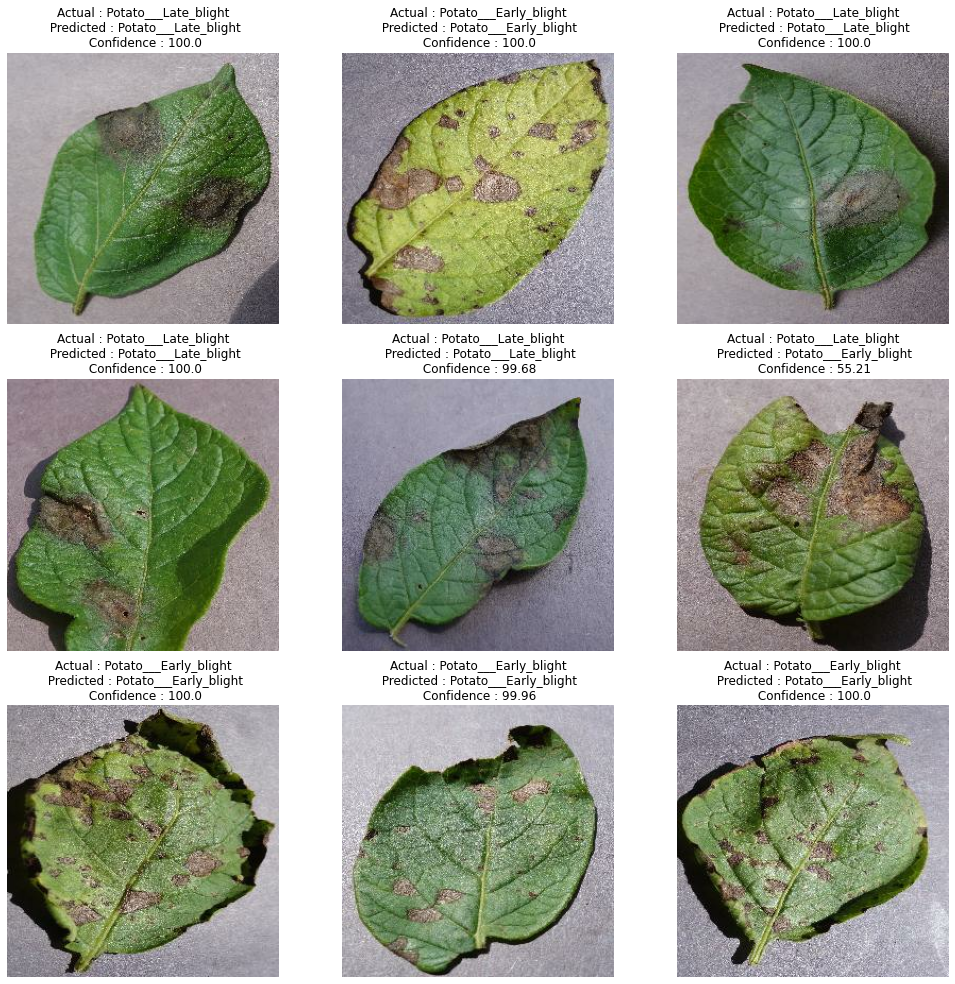

In [64]:
plt.figure(figsize=(17,17))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax=plt.subplot(3,3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

    predicted_class, confidence=predict(model, images[i])
    actual_class=class_names[labels[i]]

    plt.title(f"Actual : {actual_class}\n Predicted : {predicted_class}\n Confidence : {confidence}")

In [51]:
model_version=1
model.save(f"/content/drive/MyDrive/Colab Notebooks/Potato disease Project/Models/{model_version}")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Potato disease Project/Models/1/assets


In [54]:
latest_model=max([int(i) for i in os.listdir("/content/drive/MyDrive/Colab Notebooks/Potato disease Project/Models/")])
latest_model

1

In [ ]:
# model.save(f"/content/drive/MyDrive/Colab Notebooks/Potato disease Project/Models/{latest_model+1}")